# Event-based training of SNNs in Jax

In this notebook, we will explore how to write event based software to do gradient-based learning with spiking neural networks (SNN) in [jax](https://github.com/google/jax/).
We will implement the dynamics of a single LIF Neuron, scale it to multiple neurons, implement a simple root solver and then try to solve a classifiying task with our implementation in the beginners sections.

In [1]:
import jax
import jax.numpy as np
import matplotlib.pyplot as plt
from functools import partial
import dataclasses
from typing import Generic, Any, Union, TypeVar
import tree_math

from jax.config import config

config.update("jax_debug_nans", True)

We start off with the parameters we need to define the dynamics of the [LIF Neuron](https://www.nature.com/articles/s41598-017-07418-y). 
We dynamics are then given by two linear differential equations:
$$\tau_m \dot{V} = -V + I$$
and
$$\tau_s \dot{I} = I$$


In [2]:
ArrayLike = Union[np.ndarray, float]
Array = Union[np.ndarray, np.ndarray]


@dataclasses.dataclass
@tree_math.struct
class LIFParameters:
    tau_syn_inv: ArrayLike = 1.0 / 5e-3
    tau_mem_inv: ArrayLike = 1.0 / 1e-2
    v_leak: ArrayLike = 0.0
    v_th: ArrayLike = 0.6
    v_reset: ArrayLike = 0.0

    @property
    def tau_syn(self):
        return 1 / self.tau_syn_inv

    @property
    def tau_mem(self):
        return 1 / self.tau_mem_inv

    @property
    def dynamics(self):
        return np.array([[-self.tau_mem_inv, self.tau_mem_inv], [0, -self.tau_syn_inv]])

Above equations can be written as an exponential flow in jax by using `linalg.expm`.

In [3]:
p = LIFParameters()


def dynamics(x0, t):
    return np.dot(jax.scipy.linalg.expm(p.dynamics * t), x0)


def lif_dynamics(x0, t):
    tau_exp = np.exp(-t / p.tau_mem)
    syn_exp = np.exp(-t / p.tau_syn)
    A = np.array(
        [
            [tau_exp, p.tau_syn / (p.tau_mem - p.tau_syn) * (tau_exp - syn_exp)],
            [0, syn_exp],
        ]
    )
    return np.dot(A, x0)

We use [jax.vmap](https://jax.readthedocs.io/en/latest/_autosummary/jax.vmap.html) to vectorize over the leading axis and apply the LIF dynamic to multiple times steps.

56.4 µs ± 1.93 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
16 µs ± 1.61 µs per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


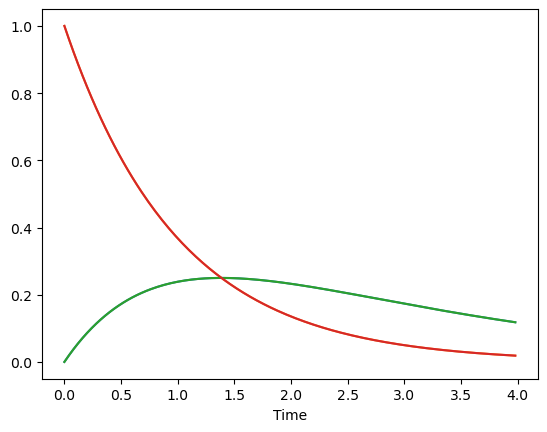

In [4]:
y0 = np.array([0.0, 1.0])
xs = np.arange(0, 4.0 * p.tau_syn, 1e-4)

batched_dynamics = jax.jit(jax.vmap(partial(dynamics, y0)))
batched_custom_dynamics = jax.jit(jax.vmap(partial(lif_dynamics, y0)))

ys = batched_dynamics(xs).block_until_ready()
ys2 = batched_custom_dynamics(xs).block_until_ready()
%timeit ys = batched_dynamics(xs).block_until_ready()
%timeit ys2 = batched_custom_dynamics(xs).block_until_ready()

plt.xlabel("Time")
plt.plot(xs / p.tau_syn, ys)
plt.plot(xs / p.tau_syn, ys2)
plt.show()

Now, we might want to work with more explicit datastructures, where we can access attribute by name rather than index. We introduce the LIFState which keeps track of the current (I) and voltage (V) of one or multiple neurons. We use `tree_flatten` and `tree_unflatten` to convert between the struct and the array which the dynamics function receives as input.

In [5]:
from jax.tree_util import tree_flatten, tree_unflatten

t_late = 2 * p.tau_syn
t_max = 4 * p.tau_syn


@dataclasses.dataclass
@tree_math.struct
class LIFState:
    V: np.ndarray
    I: np.ndarray


def tree_wrap(func):
    def tree_wrap(*args):
        values, tree_def = tree_flatten(args[0])
        res = func(np.stack(values), *args[1:])
        return tree_unflatten(tree_def, res)

    return tree_wrap


wrapped_dynamics = tree_wrap(dynamics)

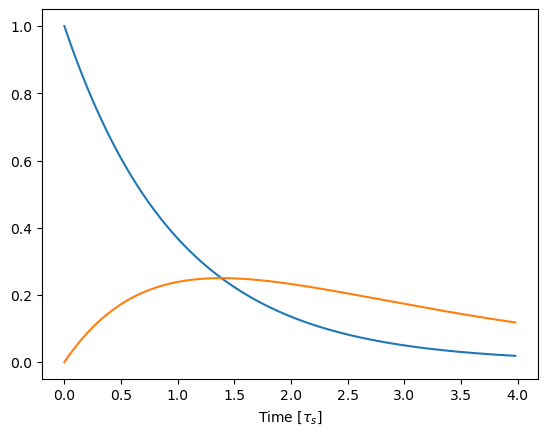

In [6]:
state = LIFState(V=np.array([0.0]), I=np.array([1.0]))
xs = np.arange(0, t_max, 1e-4)
ys = jax.vmap(partial(wrapped_dynamics, state))(xs)

plt.xlabel(r"Time $[\tau_s]$")
plt.plot(xs / p.tau_syn, ys.I)
plt.plot(xs / p.tau_syn, ys.V)
plt.show()

In order to determine whether any jump had occured it is sufficient to focus on a given time interval $[t_k, t_{k+1}]$, we can then consider a jump condition $j$, for example one that is affine
$$j(t) = P y(t) - b$$
and do a root finding procedure on this interval. For $\tau_m = 2\tau_s$, there exists an analytical solution for the time of the spike [[Göltz et al.](https://arxiv.org/abs/1912.11443)].


Identifying $a_1 = I_0$ and $a_2 = V_0 + I_0$, the time of the first spike for a neuron is given by

$$\frac{T}{\tau_m} = \log\left(\frac{2a_1}{a_2 + \sqrt{a_2^2 - 4a_1\vartheta}}\right)$$

In [8]:
def ttfs_inner_most(a_1, denominator, tau_mem, dt):
    inner_log = 2 * a_1 / denominator
    return jax.lax.cond(
        inner_log > 1,
        lambda: tau_mem * np.log(np.maximum(inner_log, 1)),
        lambda: dt,
    )


def ttfs_inner(a_1, a_2, second_term, tau_mem, dt):
    epsilon = 1e-7
    denominator = a_2 + np.sqrt(np.maximum(second_term, epsilon))
    save_denominator = np.sign(denominator) * np.maximum(np.abs(denominator), epsilon)
    return jax.lax.cond(
        np.abs(denominator) > epsilon,
        ttfs_inner_most,
        lambda *args: dt,
        a_1,
        save_denominator,
        tau_mem,
        dt,
    )


def ttfs_solver(tau_mem, v_th, state, dt):
    v_0, i_0 = state.V, state.I
    a_1 = i_0
    a_2 = v_0 + i_0
    second_term = a_2**2 - 4 * a_1 * v_th
    has_spike = second_term > 0
    return jax.lax.cond(
        has_spike, ttfs_inner, lambda *args: dt, a_1, a_2, second_term, tau_mem, dt
    )


solver = partial(ttfs_solver, p.tau_mem, p.v_th)

The rather cumbersome definition of the solver is due to the fact that we need to avoid any NaNs in `jax`. [jax.lax.cond](https://jax.readthedocs.io/en/latest/_autosummary/jax.lax.cond.html) will (when transformed with `jax.vmap` to evaluate over a batch) in general execute both branches. Even if the NaNs do not affect the result of the forward pass, they will set  status flags and lead to NaNs in the gradient. If no spike is found, the solver will return `dt` as spike time.

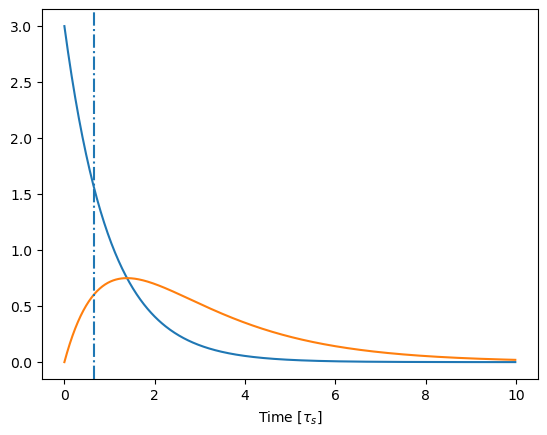

In [9]:
y0 = LIFState(V=np.array(0.0), I=np.array(3.0))
xs = np.arange(0, 5e-2, 1e-4)

ys = jax.vmap(partial(wrapped_dynamics, y0))(xs)
spike_time = solver(y0, t_max)

plt.xlabel(r"Time $[\tau_s]$")
plt.plot(xs / p.tau_syn, ys.I)
plt.plot(xs / p.tau_syn, ys.V)
if spike_time != t_max:
    plt.axvline(spike_time / p.tau_syn, linestyle="-.")
plt.show()

So we are able to find the time of the threshold crossing for one neuron. To find the next spike times for multiple neurons, we use `jax.vmap` to evaluate the function over the state of three neurons. In this example, only the third neuron with the highes input current emits a spike.

In [10]:
n_neurons = 3
neuron_state = LIFState(V=np.zeros(n_neurons), I=np.arange(1, 1 + n_neurons))
batched_solver = jax.vmap(solver, in_axes=(0, None))
batched_solver(neuron_state, t_max)

Array([0.02      , 0.02      , 0.00323507], dtype=float32)

Next, we will define the class which holds one or multiple spike events.

In [11]:
@dataclasses.dataclass
@tree_math.struct
class Spike:
    time: np.ndarray
    idx: np.ndarray

    def __getitem__(self, key):
        return Spike(self.time[key], self.idx[key])

Also, an input queue which will be used to loop over input spikes is defined.

In [12]:
@dataclasses.dataclass
@tree_math.struct
class InputQueue:
    spikes: Spike
    head: int = 0

    @property
    def is_empty(self) -> bool:
        return self.head == len(self.spikes.time)

    def peek(self) -> Spike:
        return self.spikes[self.head]

    def pop(self) -> Spike:
        spike = self.spikes[self.head]
        self.head += 1
        return spike

We also need to define how an input spike changes the state of the hidden neurons.

In [13]:
def input_transition(neuron_state, input_queue, weights):
    spike = input_queue.pop()
    tr_row = weights[spike.idx]
    neuron_state.I = neuron_state.I + tr_row
    return neuron_state, input_queue

We can now step through the input spikes and observe the dynamics of one neuron. In this case, we set up the input queue with four input spikes from two different neurons.

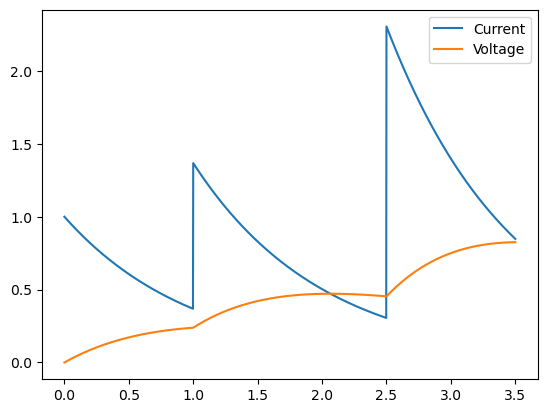

In [14]:
weights = np.array([[1], [2]])
neuron_state = LIFState(V=np.zeros(1), I=np.zeros(1))

input_spikes = Spike(
    time=np.array([0.0, 1.0, 2.5, 3.5]) * p.tau_syn, idx=np.array([0, 0, 1, 1])
)
input_queue = InputQueue(input_spikes)

observe, time = [], 0.0
for i in range(len(input_spikes.time)):
    next_spike_time = input_queue.peek().time

    ts = np.arange(time, next_spike_time, 1e-5)
    observe.append(
        (ts, jax.vmap(wrapped_dynamics, in_axes=(None, 0))(neuron_state, ts - time))
    )

    neuron_state = wrapped_dynamics(neuron_state, next_spike_time - time)
    time = next_spike_time
    neuron_state, input_queue = input_transition(neuron_state, input_queue, weights)

ts = np.hstack([o[0] for o in observe]) / p.tau_syn
plt.plot(ts, np.vstack([o[1].I for o in observe]), label="Current")
plt.plot(ts, np.vstack([o[1].V for o in observe]), label="Voltage")
plt.legend()
plt.show()

### Step Function

Our next goal is to define a `step` function, which takes us from one event to the next one. We can use the inner part of the above loop as a first implementation.

In [15]:
def step(neuron_state, input_queue, weights, observe, time):
    next_spike_time = input_queue.peek().time

    ts = np.arange(time, next_spike_time, 1e-5)
    observe.append(
        (ts, jax.vmap(wrapped_dynamics, in_axes=(None, 0))(neuron_state, ts - time))
    )

    neuron_state = wrapped_dynamics(neuron_state, next_spike_time - time)
    time = next_spike_time
    neuron_state, input_queue = input_transition(neuron_state, input_queue, weights)

    return neuron_state, input_queue, weights, observe, time

And run the same experiment again

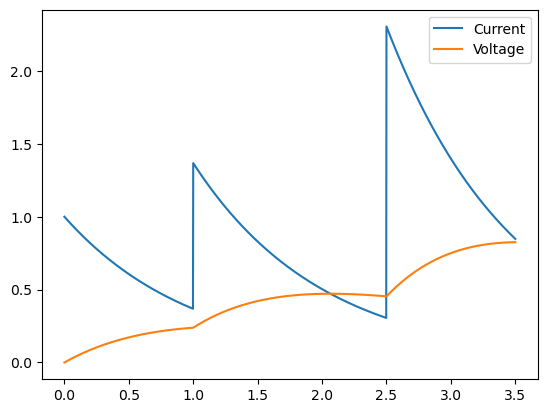

In [16]:
weights = np.array([[1], [2]])
neuron_state = LIFState(V=np.zeros(1), I=np.zeros(1))

input_spikes = Spike(
    time=np.array([0.0, 1.0, 2.5, 3.5]) * p.tau_syn, idx=np.array([0, 0, 1, 1])
)
input_queue = InputQueue(input_spikes)

observe, time = [], 0.0
for i in range(len(input_spikes.time)):
    neuron_state, input_queue, weights, observe, time = step(
        neuron_state, input_queue, weights, observe, time
    )

ts = np.hstack([o[0] for o in observe]) / p.tau_syn
plt.plot(ts, np.vstack([o[1].I for o in observe]), label="Current")
plt.plot(ts, np.vstack([o[1].V for o in observe]), label="Voltage")
plt.legend()
plt.show()

We now have a function that iterates through the input spikes and applies them to the hidden neuron. What is missing, however, is the handling of internal spikes. We need to detect wether an internal event has occured before the next external spike.

We start by defining what happens on an internal transition. We also update the input transition function to have the same signature on both of these functions.

In [17]:
def internal_transition(neuron_state, input_queue, weights, spike_idx):
    neuron_state.V = neuron_state.V.at[spike_idx].set(p.v_reset)

    # Recursion
    # neuron_state.I = neuron_state.I + recursive_weights[spike.idx]
    #

    return neuron_state, input_queue


def input_transition(neuron_state, input_queue, weights, spike_idx):
    spike = input_queue.pop()
    tr_row = weights[spike.idx]
    neuron_state.I = neuron_state.I + tr_row
    return neuron_state, input_queue

Note that we could have implemented recursion in the `internal_transition` function but rather go for a simple non-recursive LIF Neuron which quielty resets it's voltage.

### Internal or external event?

We now use the (analytical) root solver, to find the time of the next internal event. We compare it with the next event from the input queue and such find the next event (external or internal). We integrate the dynamics up until the event, apply the transition and return the state.

In [18]:
def step(neuron_state, input_queue, weights, observe, time):
    pred_spikes = batched_solver(neuron_state, t_max) + time
    spike_idx = np.argmin(pred_spikes)

    # determine spike nature and time of next event (t_dyn)
    next_input_spike_time = jax.lax.cond(
        input_queue.is_empty, lambda: t_max, lambda: input_queue.peek().time
    )
    t_dyn = np.minimum(pred_spikes[spike_idx], next_input_spike_time)

    ts = np.arange(time, t_dyn, 1e-4)
    observe.append(
        (ts, jax.vmap(wrapped_dynamics, in_axes=(None, 0))(neuron_state, ts - time))
    )
    neuron_state = wrapped_dynamics(neuron_state, t_dyn - time)
    time = t_dyn

    spike_in_layer = pred_spikes[spike_idx] < next_input_spike_time

    if spike_in_layer:
        neuron_state, input_queue = internal_transition(
            neuron_state, input_queue, weights, spike_idx
        )
    else:
        neuron_state, input_queue = input_transition(
            neuron_state, input_queue, weights, spike_idx
        )

    return neuron_state, input_queue, weights, observe, t_dyn, spike_in_layer

This step function is very close to the final version. If we loop over it, we it applies input and internal spikes.

0.00 tau_s: External spike
1.00 tau_s: External spike
2.50 tau_s: External spike
2.69 tau_s: Internal spike
3.50 tau_s: External spike
3.67 tau_s: Internal spike
4.00 tau_s: External spike


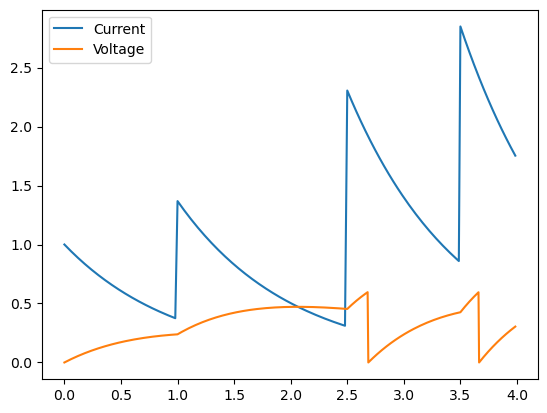

In [19]:
weights = np.array([[1], [2]])
neuron_state = LIFState(V=np.zeros(1), I=np.zeros(1))

input_spikes = Spike(
    time=np.array([0.0, 1.0, 2.5, 3.5]) * p.tau_syn, idx=np.array([0, 0, 1, 1])
)
input_queue = InputQueue(input_spikes)
observe, time = [], 0.0
for i in range(len(input_spikes.time) + 3):
    neuron_state, input_queue, weights, observe, time, spike_in_layer = step(
        neuron_state, input_queue, weights, observe, time
    )
    print(
        f"{time / p.tau_syn:.2f} tau_s: {('External', 'Internal')[int(spike_in_layer)]} spike"
    )

ts = np.hstack([o[0] for o in observe]) / p.tau_syn
plt.plot(ts, np.vstack([o[1].I for o in observe]), label="Current")
plt.plot(ts, np.vstack([o[1].V for o in observe]), label="Voltage")
plt.legend()
plt.show()

In the voltage trace, we can see that the neuron spikes two times, at $t=2.69\tau_s$ and at $t=3.67\tau_s$.
We combine the arguments which are received and returned from the `step` function into a single class `StepState` and update the function signature.

In [20]:
State = TypeVar("State")


@dataclasses.dataclass
@tree_math.struct
class StepState(Generic[State]):
    neuron_state: State
    time: float
    input_queue: InputQueue


def internal_transition(state: StepState, weights, spike_idx):
    state.neuron_state.V = state.neuron_state.V.at[spike_idx].set(p.v_reset)
    return state


def input_transition(state: StepState, weights, spike_idx):
    spike = state.input_queue.pop()
    tr_row = weights[spike.idx]
    state.neuron_state.I = state.neuron_state.I + tr_row
    return state

Also, we use [jax.lax.cond](https://jax.readthedocs.io/en/latest/_autosummary/jax.lax.cond.html) instead of the traditional `if` and `else`, because we want to use `jax.jit` to compile the step function later on. Note that we drop the observation and return just the event that happenend as observation. If the spike is an input spike, the stored index is set to -1.

In [21]:
def step(input: tuple[StepState, Any], iteration: int):
    state, weights = input

    pred_spikes = batched_solver(state.neuron_state, t_max) + state.time
    spike_idx = np.argmin(pred_spikes)

    next_input_spike_time = jax.lax.cond(
        state.input_queue.is_empty, lambda: t_max, lambda: state.input_queue.peek().time
    )
    t_dyn = np.minimum(pred_spikes[spike_idx], next_input_spike_time)
    state = StepState(
        neuron_state=wrapped_dynamics(state.neuron_state, t_dyn - state.time),
        time=t_dyn,
        input_queue=state.input_queue,
    )

    spike_in_layer = pred_spikes[spike_idx] < next_input_spike_time
    stored_idx = jax.lax.cond(spike_in_layer, lambda: spike_idx, lambda: -1)

    state = jax.lax.cond(
        spike_in_layer,
        internal_transition,
        input_transition,
        state,
        weights,
        spike_idx,
    )

    return (state, weights), Spike(t_dyn, stored_idx)

The functions signature now exactly matched that needed for [jax.lax.scan](https://jax.readthedocs.io/en/latest/_autosummary/jax.lax.scan.html) which scans a function over leading array axes while carrying along state.

In [24]:
weights = np.array([[1], [2]])
neuron_state = LIFState(V=np.zeros(1), I=np.zeros(1))
input_spikes = Spike(
    time=np.array([0.0, 1.0, 2.5, 3.5]) * p.tau_syn, idx=np.array([0, 0, 1, 1])
)
state = StepState(
    neuron_state=neuron_state,
    time=0.0,
    input_queue=InputQueue(input_spikes),
)
n_events = 6
_, events = jax.lax.scan(step, (state, weights), np.arange(n_events))
_, events

((StepState(neuron_state=LIFState(V=Array([0.], dtype=float32), I=Array([2.414387], dtype=float32)), time=Array(0.01832593, dtype=float32), input_queue=InputQueue(spikes=Spike(time=Array([0.    , 0.005 , 0.0125, 0.0175], dtype=float32), idx=Array([0, 0, 1, 1], dtype=int32)), head=Array(4, dtype=int32, weak_type=True))),
  Array([[1],
         [2]], dtype=int32)),
 Spike(time=Array([0.        , 0.005     , 0.0125    , 0.01343071, 0.0175    ,
        0.01832593], dtype=float32), idx=Array([-1, -1, -1,  0, -1,  0], dtype=int32, weak_type=True)))

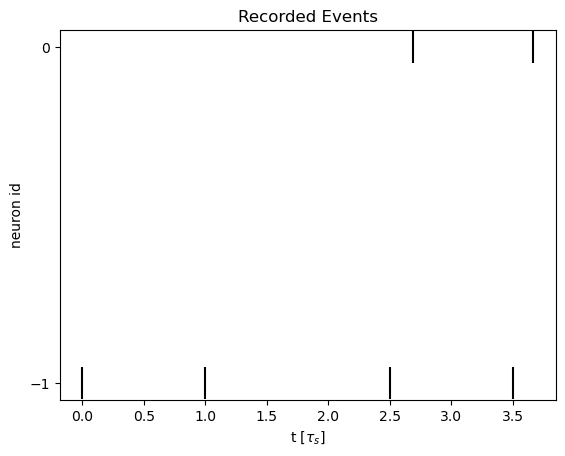

In [25]:
def plot_events(events, ticks=None):
    plt.scatter(
        x=events.time / p.tau_syn,
        y=events.idx,
        s=500,
        marker="|",
        c="black",
    )
    if ticks is not None:
        plt.yticks(ticks)
    plt.ylabel("neuron id")
    plt.xlabel(r"t $[\tau_s]$")
    plt.title("Recorded Events")
    plt.show()


plot_events(events, ticks=np.arange(-1, 1))

Up until now we have only used one neuron. But we have defined everything in such a way, that we can simply increase the number of neurons in the `LIFState` and everything magically works.

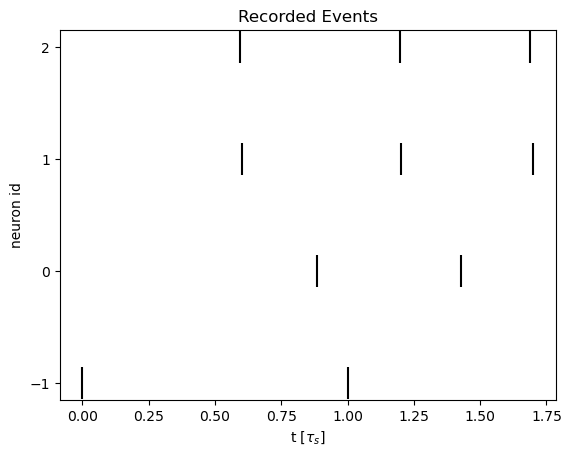

In [26]:
rng = jax.random.PRNGKey(42)

input_size = 2
hidden_size = 3
weights = jax.random.normal(rng, (input_size, hidden_size)) + 2.0
neuron_state = LIFState(V=np.zeros(hidden_size), I=np.zeros(hidden_size))
state = StepState(
    neuron_state=neuron_state,
    time=0.0,
    input_queue=InputQueue(input_spikes),
)

input_spikes = Spike(
    time=np.array([0.0, 1.0, 2.5, 3.5]) * p.tau_syn, idx=np.array([0, 0, 1, 1])
)
n_events = 10
_, events = jax.lax.scan(step, (state, weights), np.arange(n_events))
plot_events(events, ticks=np.arange(-1, hidden_size))

After the first input spike, each neuron spikes one time and after the second input spike, neuron number two and neuron number three spike two times. 

### Running out of events
But what happens if the `step` function runs for 100 iterations but we don't have this many events? We need to handle the case that no spike is happening anymore. In this case, the root solver returns `t_max`. So we create a second condition to check wether we have reached `t_max` already. If this is the case, no transition is applied.

In [27]:
def step(input: tuple[StepState, Any], iteration: int):
    state, weights = input

    pred_spikes = batched_solver(state.neuron_state, t_max) + state.time
    spike_idx = np.argmin(pred_spikes)

    next_input_spike_time = jax.lax.cond(
        state.input_queue.is_empty, lambda: t_max, lambda: state.input_queue.peek().time
    )
    t_dyn = np.minimum(pred_spikes[spike_idx], next_input_spike_time)

    state = StepState(
        neuron_state=wrapped_dynamics(state.neuron_state, t_dyn - state.time),
        time=t_dyn,
        input_queue=state.input_queue,
    )

    spike_in_layer = pred_spikes[spike_idx] < next_input_spike_time
    stored_idx = jax.lax.cond(spike_in_layer, lambda: spike_idx, lambda: -1)

    state = jax.lax.cond(
        t_dyn + 1e-7 >= t_max,
        lambda: state,
        lambda: jax.lax.cond(
            spike_in_layer,
            internal_transition,
            input_transition,
            state,
            weights,
            spike_idx,
        ),
    )

    return (state, weights), Spike(t_dyn, stored_idx)

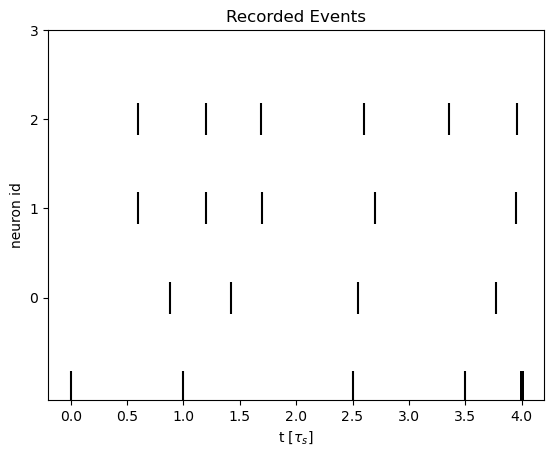

In [28]:
rng = jax.random.PRNGKey(42)

input_size = 2
hidden_size = 3
weights = jax.random.normal(rng, (input_size, hidden_size)) + 2.0
state = StepState(
    LIFState(V=np.zeros(hidden_size), I=np.zeros(hidden_size)),
    0.0,
    InputQueue(input_spikes),
)

input_spikes = Spike(
    time=np.array([0.0, 1.0, 2.5, 3.5]) * p.tau_syn, idx=np.array([0, 0, 1, 1])
)
n_events = 100
_, events = jax.lax.scan(step, (state, weights), np.arange(n_events))
plot_events(events, ticks=np.arange(0, 4))

In the plot, you can see that eventhough we run 100 iterations, no events after `t_max` are plotted, as all the remaining events are collected at `t_max`.

### Training

We have now defined a one layer network of LIF neurons and are ready to test it on a simple training task. We start by defining a linear dataset with explicitly set target times for the correct label neuron and for the wrong label neuron. We dataset consits of randomly chosen points in 2D space with the coordinates encoded by the spike times. We also mirror the coordinates and add a bias spike.

In [25]:
def linear_dataset(rng, shape):
    size = np.prod(np.array(shape))
    input = jax.random.uniform(rng, (size, 2))
    encoding = np.array([[0.9, 1.5], [1.5, 0.9]]) * p.tau_syn

    # determine the class
    which_class = (input[:, 0] < input[:, 1]).astype(int)
    target = encoding[which_class]
    spike_idx = np.array([0, 1])

    # mirror the input
    spike_idx = np.concatenate((spike_idx, np.array([2, 3])))
    input = np.hstack((input, 1 - input))

    # add a bias spike
    spike_idx = np.concatenate((spike_idx, np.array([spike_idx[-1] + 1])))
    column = np.full(size, 0.5)[:, None]
    input = np.hstack((input, column))

    input = input * t_late
    spike_idx = np.tile(spike_idx, (np.prod(np.array(shape)), 1))

    # sort spikes
    sort_idx = np.argsort(input, axis=-1)
    input = input[np.arange(input.shape[0])[:, None], sort_idx]
    spike_idx = spike_idx[np.arange(spike_idx.shape[0])[:, None], sort_idx]

    input_spikes = Spike(
        input.reshape(*(shape + [-1])), spike_idx.reshape(*(shape) + [-1])
    )

    target = target.reshape(*(shape + [2]))
    return (input_spikes, target)


rgn = jax.random.PRNGKey(42)
dataset = linear_dataset(rng, shape=[5000])

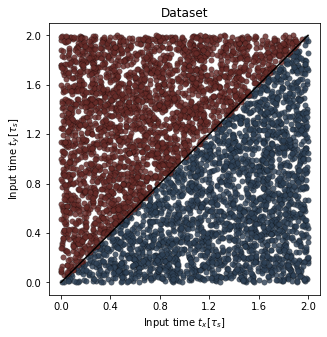

In [26]:
import numpy as onp

blue = onp.array([[47, 66, 87, 210]]) / 256
red = onp.array([[103, 43, 40, 210]]) / 256
black = onp.array([[0, 0, 0, 0.3]])


def plt_dataset(ax, dataset):
    n_classes = dataset[1].shape[-1]
    input_size = dataset[0].time.shape[-1]
    dataset = (
        Spike(
            dataset[0].time.reshape(-1, input_size),
            dataset[0].idx.reshape(-1, input_size),
        ),
        dataset[1].reshape(-1, n_classes),
    )
    # bias spike is on channel 5
    np.argwhere(dataset[0].idx == 2)

    x_ix = np.argwhere(dataset[0].idx == 0)
    x = dataset[0].time[x_ix[:, 0], x_ix[:, 1]] / p.tau_syn

    y_ix = np.argwhere(dataset[0].idx == 1)
    y = dataset[0].time[y_ix[:, 0], y_ix[:, 1]] / p.tau_syn

    label = np.argmin(dataset[1], axis=-1).flatten()
    for i, color in zip(range(n_classes), (blue, red)):
        ax.scatter(
            x[label == i],
            y[label == i],
            s=30,
            facecolor=color,
            edgecolor=black,
            linewidths=0.7,
        )

    ax.plot(np.linspace(0, 2, 100), np.linspace(0, 2, 100), c="k")
    ax.set_xlabel(r"Input time $t_x [\tau_s]$")
    ax.set_ylabel(r"Input time $t_y [\tau_s]$")
    ax.set_xticks(np.linspace(0.0, 2, 6))
    ax.set_yticks(np.linspace(0.0, 2, 6))
    ax.set_title("Dataset")
    ax.set_aspect("equal")


fig, ax = plt.subplots(1, figsize=(8, 5))
plt_dataset(ax, dataset)

In order to do a gradient descent on this dataset, we need to define a loss function based on the spike time. If the loss is based on the time of the first spikes, we need to find the first spike time for each neuron based on the output events of one layer. This function needs to know the number of neuron, as the events do only tell about neurons that have spiked.

In [27]:
def first_spike(spikes: Spike, size: int) -> Array:
    return np.array(
        [
            np.min(np.where(spikes.idx == idx, spikes.time, np.inf))
            for idx in range(size)
        ]
    )


first_spike(events, 2)

DeviceArray([0.00442345, 0.00300397], dtype=float32)

Now we define a MSE Loss between the first spikes of the layer and the target times (which are defined in the dataset).
$$L = \sum_i\left(y_i - \hat{y_i}\right)^2$$

In [28]:
def mse_loss(first_spikes, target):
    return np.sum(
        np.square((np.minimum(first_spikes, 2 * p.tau_mem) - target) / p.tau_mem)
    )


mse_loss(first_spike(events, 2), dataset[1][0])

DeviceArray(0.11703277, dtype=float32)

With these component, we can write a loss function which takes the parameters of the layer and the batch as input and returns a scalar loss.

In [29]:
hidden_size = 2
input_size = 4


def apply_fn(params, input_spikes):
    n_events = 9  # 5 input spikes + 4 internal spikes
    state = StepState(
        LIFState(V=np.zeros(hidden_size), I=np.zeros(hidden_size)),
        0.0,
        InputQueue(input_spikes),
    )
    _, events = jax.lax.scan(jax.jit(step), (state, params), np.arange(n_events))
    return events


def loss_fn(
    apply_fn,
    loss_fn,
    params,
    batch,
):
    input_spikes, target = batch
    recording = apply_fn(params, input_spikes)

    t_first_spike = first_spike(recording, params.shape[1])
    loss_value = loss_fn(t_first_spike, target)
    return loss_value, (t_first_spike, recording)


loss = partial(loss_fn, apply_fn, mse_loss)

Further we define a train and test function. We use `jax.grad` to optain gradients with respect to the input parameters, and then iteratively update these parameters.

In [30]:
def train(params):
    values = []
    grad_fn = jax.jit(jax.value_and_grad(loss, has_aux=True))
    for i in range(1000):
        batch = (dataset[0][i], dataset[1][i])
        (loss_value, (t_first_spike, recording)), grad = grad_fn(params, batch)
        params = jax.tree_map(lambda f, df: f - 0.1 * df, params, grad)
        values.append(loss_value)
    return params


def test(params):
    accuracy = []
    for i in range(1000):
        batch = (dataset[0][i], dataset[1][i])
        loss_value, (t_first_spike, recording) = jax.jit(loss)(params, batch)
        accuracy.append(np.argmin(t_first_spike) == np.argmin(dataset[1][i]))
    return np.mean(np.array(accuracy))


params = jax.random.normal(rng, (input_size, hidden_size)) + 2.0
params = train(params)
acc = test(params)
print(f"Achieved an accuracy of {acc * 100:.1f}% on the linear dataset")

Achieved an accuracy of 89.2% on the linear dataset


We can use jax primitives to add batching to this training task. All we do is use `jax.vmap` to map over the apply function.

In [31]:
def batch_wrapper(fn):
    def wrapped_fn(*args, **kwargs):
        res = jax.vmap(fn, in_axes=(None, 0))(*args, **kwargs)
        return np.sum(res[0]), res[1]

    return wrapped_fn


batched_loss = batch_wrapper(loss)

batch = (dataset[0][0:10], dataset[1][0:10])
params = jax.random.normal(rng, (input_size, hidden_size)) + 2.0
print(f"Loss on the first ten samples: {batched_loss(params, batch)[0]:.3f}")

Loss on the first ten samples: 1.294


We use `jax.grad` to get the derivative with respect to the weights and apply the updates to the weights. Note that the update function can be scaned over as it carries the weights alon, which makes our train function very simple. `Scan` also compiles the `update` function for us to make the computation more efficient.

In [35]:
@jax.jit
def update(params, batch):
    value, grad = jax.value_and_grad(batched_loss, has_aux=True)(params, batch)
    params = jax.tree_map(lambda f, df: f - 0.1 * df, params, grad)
    return params, value


def train(params, dataset):
    return jax.lax.scan(update, params, dataset)


def test(params, dataset):
    loss_value, (t_first_spike, recording) = jax.vmap(batched_loss, in_axes=(None, 0))(
        params, dataset
    )
    accuracy = np.argmin(dataset[1], axis=-1) == np.argmin(t_first_spike, axis=-1)
    return np.mean(accuracy), t_first_spike

In [36]:
dataset = linear_dataset(rng, [200, 10])
params = jax.random.normal(rng, (input_size, hidden_size)) + 2.0

params, values = train(params, dataset)
acc, t_first_spike = test(params, dataset)
print(f"Achieved an accuracy of {acc * 100:.1f}% on the linear dataset")

Achieved an accuracy of 93.7% on the linear dataset


But how do the outputs of the network look like? We can plot the spike times for the two output neurons.

In [37]:
import matplotlib as mpl


def plt_t_spike_neuron(fig, axs, dataset, t_spike):
    names = ("First", "Second", "Third")
    n_neurons = t_spike.shape[-1]
    t_spike = t_spike.reshape(-1, n_neurons)

    # reshape
    n_classes = dataset[1].shape[-1]
    input_size = dataset[0].time.shape[-1]
    dataset = (
        Spike(
            dataset[0].time.reshape(-1, input_size),
            dataset[0].idx.reshape(-1, input_size),
        ),
        dataset[1].reshape(-1, n_classes),
    )

    x_ix = np.argwhere(dataset[0].idx == 0)
    x = dataset[0].time[x_ix[:, 0], x_ix[:, 1]] / p.tau_syn

    y_ix = np.argwhere(dataset[0].idx == 1)
    y = dataset[0].time[y_ix[:, 0], y_ix[:, 1]] / p.tau_syn

    # normalize all neurons with the same value
    cmap = mpl.colormaps["magma"]
    normalize = np.nanpercentile(np.where(t_spike == np.inf, np.nan, t_spike), 95)
    for i in range(n_neurons):
        score = t_spike[:, i]
        score_no_inf = score[score != np.inf]
        color_ix = np.rint(score_no_inf * 256 / normalize).astype(int)
        colors = cmap(color_ix)
        axs[i].scatter(
            x[score != np.inf],
            y[score != np.inf],
            s=30,
            facecolor=colors,
            edgecolor=black,
            linewidths=0.7,
        )
        axs[i].scatter(
            x[score == np.inf], y[score == np.inf], facecolor=black, edgecolor=black
        )
        axs[i].plot(
            np.linspace(0, t_late / p.tau_syn, 100),
            np.linspace(0, t_late / p.tau_syn, 100),
            c="k",
        )
        axs[i].set_xlabel(r"Input time $t_x [\tau_s]$")
        axs[i].set_xticks(np.linspace(0, t_late / p.tau_syn, 5))
        axs[i].set_yticks(np.linspace(0, t_late / p.tau_syn, 5))
        axs[i].title.set_text(f"{names[i]} neuron")
        axs[i].set_aspect("equal")
    axs[0].set_ylabel(r"Input time $t_y [\tau_s]$")

    # Normalizer
    norm = mpl.colors.Normalize(vmin=0, vmax=normalize / p.tau_syn)

    # creating ScalarMappable
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    cbar = fig.colorbar(sm, ax=axs, location="right")
    cbar.ax.set_ylabel(r"$t_{spike}[\tau_s]$", rotation=90, fontsize=13)
    fig.subplots_adjust(bottom=0.15, right=0.7, top=0.9)

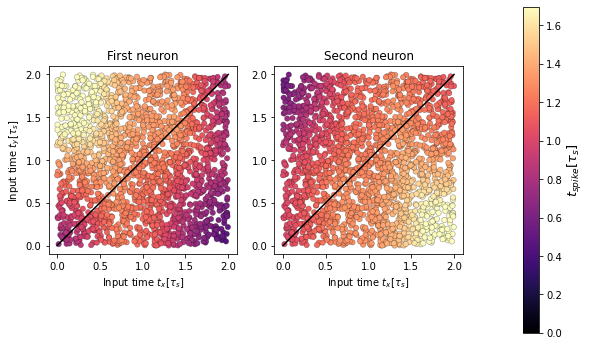

In [38]:
fig, axs = plt.subplots(1, 2, figsize=(10, 6))
plt_t_spike_neuron(fig, axs, dataset, t_first_spike)

## Advanced Training

This marks the end of the beginners section of this notebook. We have learned how to

* write the dynamics of the LIF Neuron in `jax`
* how to 

In [ ]:
# scheduler = optax.exponential_decay(step_size, n_train_batches, lr_decay)

# optimizer = optimizer_fn(scheduler)
# opt_state = optimizer.init(params)